# Food we all love! 
## forecasting everyday sales using data from Polish pizzeria
<img src="https://images.services.local.ch/bp/localplace-images/28/289b800f9d19a822c4c3e307538f745842edc360/pizzeria2.png?center=0.500000%2C0.588964&scale=crop&size=768x198&v=1&sig=e3847520e295d61d051ebd8d40f89c9d3044cbf4fc485cd4efab6f218fefe682" width=100% ></img>

## Table of contents:
1. [Import necessary libraries](#import)
1. [Data import and very basic analysis](#data)
1. [We create a new DataFrame where we store daily pizza sales](#days)
1. [Deeper understanding of data](#deeper)
1. [Creating a model](#model)
    1. [x] Baseline
    2. [x] Simple ML models - linear regression, gradient boosting regression
    3. [x] Moving average forecasting
    4. [ ] Simple Deep Learning models - with time windows
    5. [ ] Fast Fourier Transformation
    7. [ ] Advanced Deep Learning models:
        * [ ] seq2seq
        * [x] RNNs
        * [ ] CNNs

1. <a id="import"></a>
### 1.  Import necessary libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import datasets, ensemble
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import GradientBoostingRegressor

<a id="data"></a>
### 2. Data import and very basic analysis

In [101]:
pizza_data = pd.read_csv('data/pizza_data.csv')

In [102]:
# We drop the first day because it was not full - it startes at 12.00 pm not at 12.00 am as every other day.
pizza_data.drop(pizza_data.loc[(pizza_data.year==2016) & (pizza_data.month==10) & (pizza_data.day==11)].index,
                inplace=True)

In [103]:
pizza_data.head()

,count,year,month,day,hour,working_day,weekend_day,public_holiday
12,0,2016,10,12,0,1,0,0
13,0,2016,10,12,1,1,0,0
14,0,2016,10,12,2,1,0,0
15,0,2016,10,12,3,1,0,0
16,0,2016,10,12,4,1,0,0


In [104]:
pizza_data = pizza_data.rename(columns={'count':'pizza_count'})

In [105]:
print("Shape:", pizza_data.shape)
print("Size:", pizza_data.size)

Shape: (14760, 8)
Size: 118080


We have 14760 rows with data. Each row shows the number of pizzas sold in that hour

In [106]:
# We check if there are depandancies between 3 columns listed below - in order to erase one if does not add new info
print(pizza_data.loc[pizza_data.working_day==1].weekend_day.sum())
print(pizza_data.loc[pizza_data.weekend_day==1].working_day.sum())
print(pizza_data.loc[pizza_data.weekend_day==1].public_holiday.sum())
print(pizza_data.loc[pizza_data.working_day==1].public_holiday.sum())

0
0
192
0


In [107]:
pizza_data = pizza_data.drop(columns=['weekend_day'])  # Weekend_day can be dropped - 0 entropy

In [108]:
pizza_data.columns

Index(['pizza_count', 'year', 'month', 'day', 'hour', 'working_day',
       'public_holiday'],
      dtype='object')

In [109]:
pizza_data.tail()

,pizza_count,year,month,day,hour,working_day,public_holiday
14767,0,2018,6,19,10,1,0
14768,1,2018,6,19,11,1,0
14769,13,2018,6,19,12,1,0
14770,7,2018,6,19,13,1,0
14771,1,2018,6,19,14,1,0


In [110]:
pizza_data.describe()

,pizza_count,year,month,day,hour,working_day,public_holiday
count,14760.000000,14760.000000,14760.000000,14760.000000,14760.000000,14760.000000,14760.000000
mean,4.258875,2017.144038,6.255285,15.708198,11.494715,0.686382,0.040515
std,5.969499,0.621442,3.657837,8.741549,6.922106,0.463979,0.197170
min,0.000000,2016.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,2017.000000,3.000000,8.000000,5.000000,0.000000,0.000000
50%,0.000000,2017.000000,6.000000,16.000000,11.000000,1.000000,0.000000
75%,8.000000,2018.000000,10.000000,23.000000,17.000000,1.000000,0.000000
max,35.000000,2018.000000,12.000000,31.000000,23.000000,1.000000,1.000000


In [111]:
# Count number of datapoints (days) each year
number_of_2016_datapoints = pizza_data.loc[pizza_data.year==2016].day.count()
number_of_2017_datapoints = pizza_data.loc[pizza_data.year==2017].day.count()
number_of_2018_datapoints = pizza_data.loc[pizza_data.year==2018].day.count()

# Sum of pizza sold each year
pizza_sold_in_2016 = pizza_data.loc[pizza_data.year==2016].pizza_count.sum()
pizza_sold_in_2017 = pizza_data.loc[pizza_data.year==2017].pizza_count.sum()
pizza_sold_in_2018 = pizza_data.loc[pizza_data.year==2018].pizza_count.sum()

print("Mean of 2016 (sold/days): ", pizza_sold_in_2016/number_of_2016_datapoints)
print("Mean of 2017 (sold/days): ", pizza_sold_in_2017/number_of_2017_datapoints)
print("Mean of 2018 (sold/days): ", pizza_sold_in_2018/number_of_2018_datapoints)

Mean of 2016 (sold/days):  3.6907216494845363
Mean of 2017 (sold/days):  4.304089559058716
Mean of 2018 (sold/days):  4.432611903590753


In [112]:
print("Starting point for 2016:", pizza_data.loc[pizza_data.year==2016].month.min())
print("End point for 2016:", pizza_data.loc[pizza_data.year==2016].month.max())

print("Start point for 2018:", pizza_data.loc[pizza_data.year==2018].month.min())
print("End point for 2018:", pizza_data.loc[pizza_data.year==2018].month.max())

Starting point for 2016: 10
End point for 2016: 12
Start point for 2018: 1
End point for 2018: 6


We can see that the provided data starts in October 2016 and ends in June 2018 

<a id="days"></a>

### 3. We create a new DataFrame where we store daily pizza sales (not hourly pizza sales like in input)


In [113]:
pizza_daily = pd.DataFrame(columns=pizza_data.columns)

In [114]:
for index, row in pizza_data.iterrows():
    if int(row.hour) == 0:
        pizza_daily = pizza_daily.append(row)
    elif pizza_daily.size>0:
        pizza_daily.iloc[-1, 0] += row.pizza_count

In [115]:
pizza_daily.head()

,pizza_count,year,month,day,hour,working_day,public_holiday
12,106,2016,10,12,0,1,0
36,78,2016,10,13,0,1,0
60,134,2016,10,14,0,1,0
84,152,2016,10,15,0,0,0
108,94,2016,10,16,0,0,0


In [116]:
pizza_daily['new_index'] = list(np.arange(1,pizza_daily.shape[0]+1, 1))

pizza_daily = pizza_daily.set_index('new_index')  # We rename index

pizza_daily = pizza_daily.drop(columns=['hour'])  # Hour is no longer valid as it is daily data

In [117]:
pizza_daily.head()

,pizza_count,year,month,day,working_day,public_holiday
new_index,,,,,,
1,106,2016,10,12,1,0
2,78,2016,10,13,1,0
3,134,2016,10,14,1,0
4,152,2016,10,15,0,0
5,94,2016,10,16,0,0


In [118]:
pizza_daily = pizza_daily[['year','month','day','working_day','public_holiday','pizza_count']]

In [119]:
pizza_daily = pizza_daily.astype({"year": int, "month": int, "day": int, "working_day": int, "public_holiday": int, "pizza_count": int})

In [120]:
pizza_daily.head()

,year,month,day,working_day,public_holiday,pizza_count
new_index,,,,,,
1,2016,10,12,1,0,106
2,2016,10,13,1,0,78
3,2016,10,14,1,0,134
4,2016,10,15,0,0,152
5,2016,10,16,0,0,94


<a id="deeper"></a>
### 4. Deeper understanding of data

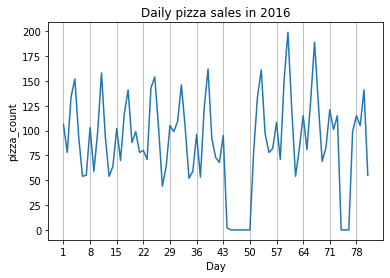

In [121]:
pizza_daily_in_2016 = pizza_daily.loc[pizza_daily.year==2016]
sns.lineplot(data = pizza_daily_in_2016,
             x = pizza_daily_in_2016.index.values,
             y = 'pizza_count')
plt.xticks(np.arange(min(pizza_daily_in_2016.index.values),
                     max(pizza_daily_in_2016.index.values),
                    7))
plt.grid(axis='x')
plt.title("Daily pizza sales in 2016")
plt.xlabel("Day")
plt.show()

From visual looking at the data from 2016 we can observe **days with no sales** but after more in-depth analysis (and knowing the data comes from **polish pizzeria**) we see that pizzeria was closed in these days **mostly due to polish national holidays**.

In [122]:
pizza_daily.loc[40:56,:] 

,year,month,day,working_day,public_holiday,pizza_count
new_index,,,,,,
40,2016,11,20,0,0,92
41,2016,11,21,1,0,73
42,2016,11,22,1,0,68
43,2016,11,23,1,0,95
44,2016,11,24,1,0,2
45,2016,11,25,1,0,0
46,2016,11,26,0,0,0
47,2016,11,27,0,0,0
48,2016,11,28,1,0,0


In [123]:
pizza_daily.iloc[70:80]  # Another holidays - christmas days 

,year,month,day,working_day,public_holiday,pizza_count
new_index,,,,,,
71,2016,12,21,1,0,121
72,2016,12,22,1,0,101
73,2016,12,23,1,0,115
74,2016,12,24,0,0,0
75,2016,12,25,0,1,0
76,2016,12,26,0,1,0
77,2016,12,27,1,0,99
78,2016,12,28,1,0,115
79,2016,12,29,1,0,105


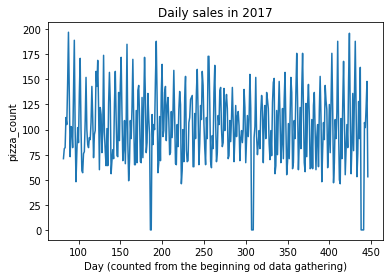

In [124]:
pizza_daily_in_2017 = pizza_daily.loc[pizza_daily.year==2017]
sns.lineplot(data = pizza_daily_in_2017,
             x=pizza_daily_in_2017.index.values,
             y='pizza_count')
plt.title("Daily sales in 2017")
plt.xlabel("Day (counted from the beginning od data gathering)")
plt.show()

In [125]:
def show_days_with_no_pizza_sold(dataframe): # Shows days with no sales and one day before and after day with 0 sales
    in_a_row = False
    new_df = pd.DataFrame(columns=list(dataframe.columns))
    
    for index, row in dataframe.iterrows():
        if row.pizza_count == 0 and in_a_row == False:
            in_a_row = True
            if index>=2:
                new_df = new_df.append(dataframe.iloc[index-2])
            new_df = new_df.append(row)
            
        elif row.pizza_count==0 and in_a_row == True:
            new_df = new_df.append(row)
            
        elif row.pizza_count!=0 and in_a_row == True:
            new_df = new_df.append(row)
            in_a_row = False
            
    return new_df

In [126]:
show_days_with_no_pizza_sold(pizza_daily)

,year,month,day,working_day,public_holiday,pizza_count
44,2016,11,24,1,0,2
45,2016,11,25,1,0,0
46,2016,11,26,0,0,0
47,2016,11,27,0,0,0
48,2016,11,28,1,0,0
49,2016,11,29,1,0,0
50,2016,11,30,1,0,0
51,2016,12,1,1,0,79
73,2016,12,23,1,0,115
74,2016,12,24,0,0,0


**Days with no sales are mostly centered over national holidays**

In [127]:
pizza_daily['weekday'] = pizza_daily.apply(
                    lambda x: datetime.date(x['year'], x['month'], x['day']).weekday(), axis=1)

In [128]:
def plot_daily_pizza(pizza_dataset, year_to_plot):
    pizza_daily_in_year_to_plot = pizza_dataset.loc[pizza_dataset.year==year_to_plot]
    plt.figure(figsize=(14,6))
    sns.lineplot(data=pizza_daily_in_year_to_plot,
                x=pizza_daily_in_year_to_plot.index.values,
                y='pizza_count',)
    sns.regplot(data=pizza_daily_in_year_to_plot,
                x=pizza_daily_in_year_to_plot.index.values,
                y='pizza_count',
               order=3)
    plt.grid(axis='x')
    xticks_weekday_list = list('Saturday' for i in pizza_daily_in_year_to_plot.iterrows())
    if pizza_daily_in_year_to_plot.loc[min(pizza_daily_in_year_to_plot.index.values)].weekday > 4:
        starting_xticks = 6 + abs(6 - pizza_daily_in_year_to_plot.loc[min(pizza_daily_in_year_to_plot.index.values)].weekday)
    else:
        starting_xticks = abs(6 - pizza_daily_in_year_to_plot.loc[min(pizza_daily_in_year_to_plot.index.values)].weekday) - 1
    plt.xticks(np.arange(min(pizza_daily_in_year_to_plot.index.values) + starting_xticks,
                         max(pizza_daily_in_year_to_plot.index.values),
                         7),
                         xticks_weekday_list, rotation=60)
    plt.title("Pizza bought daily in {}".format(year_to_plot))
    plt.xlabel("Day (weekday shown)")
    plt.ylabel("Number of pizza bought per day")
    plt.show()

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (81).

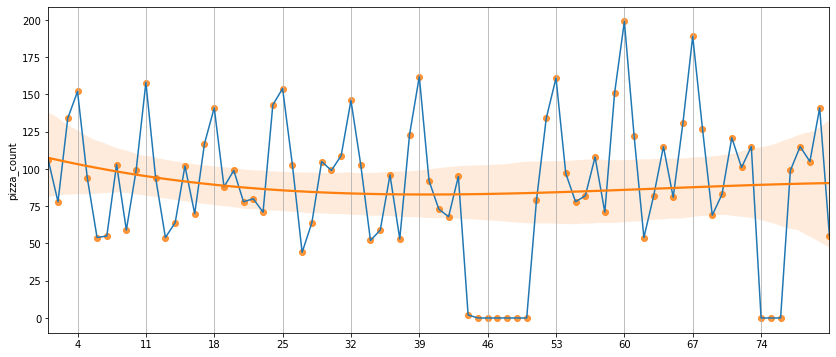

In [129]:
plot_daily_pizza(pizza_daily, 2016)

ValueError: The number of FixedLocator locations (52), usually from a call to set_ticks, does not match the number of ticklabels (365).

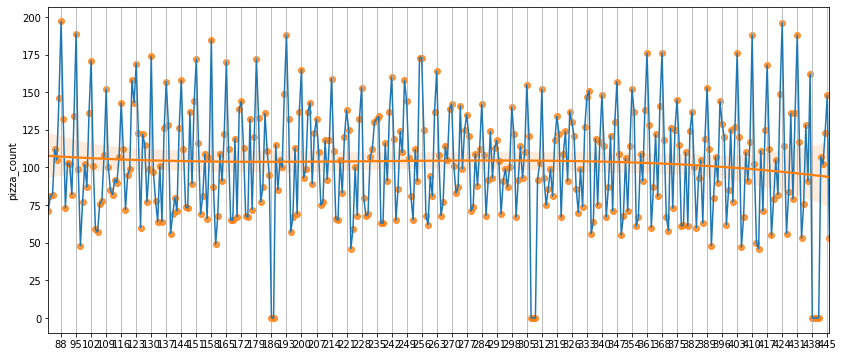

In [130]:
plot_daily_pizza(pizza_daily, 2017)

ValueError: The number of FixedLocator locations (24), usually from a call to set_ticks, does not match the number of ticklabels (170).

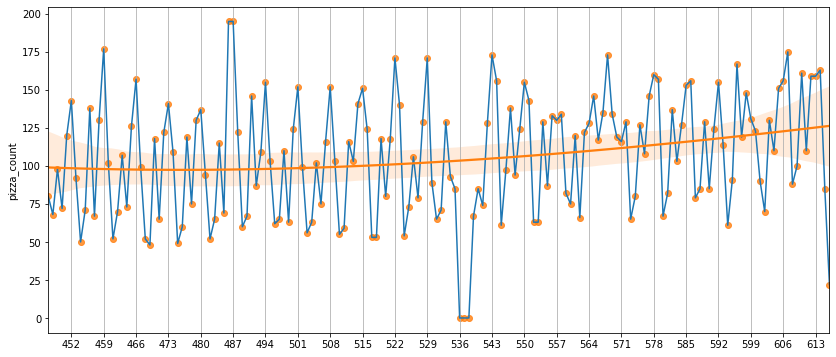

In [133]:
plot_daily_pizza(pizza_daily, 2018)

In [134]:
#pizza_daily_copy = pizza_daily.loc[pizza_daily.pizza_count!=0]
pizza_daily_copy = pizza_daily.copy()  # We create a copy to freely mess with the dataset
pizza_daily_copy.shape

(616, 7)

In [135]:
pizza_daily_copy = pizza_daily_copy.iloc[:-1]  # Erase last day from dataset as it is does not contain full 24 hours

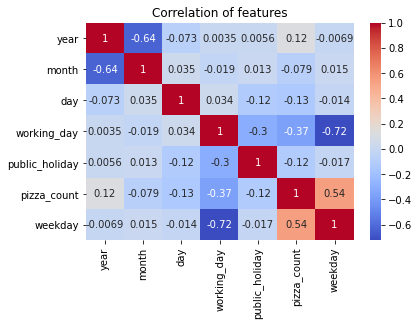

In [136]:
sns.heatmap(pizza_daily_copy.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of features")
plt.show()

In [137]:
for day_of_week in range(7):
    print('Weekday: {} Mean: {} Std: {}'.format(day_of_week,  
          np.mean(pizza_daily_copy.loc[pizza_daily_copy.weekday==day_of_week].pizza_count),
          np.std(pizza_daily_copy.loc[pizza_daily_copy.weekday==day_of_week].pizza_count),
         ))

Weekday: 0 Mean: 62.54545454545455 Std: 20.82661599694721
Weekday: 1 Mean: 73.79310344827586 Std: 21.45679322326801
Weekday: 2 Mean: 112.4090909090909 Std: 24.293955647274398
Weekday: 3 Mean: 84.38636363636364 Std: 19.235639164051367
Weekday: 4 Mean: 126.85227272727273 Std: 21.82603729323351
Weekday: 5 Mean: 146.9090909090909 Std: 41.80899108489931
Weekday: 6 Mean: 108.02272727272727 Std: 33.07978553049886


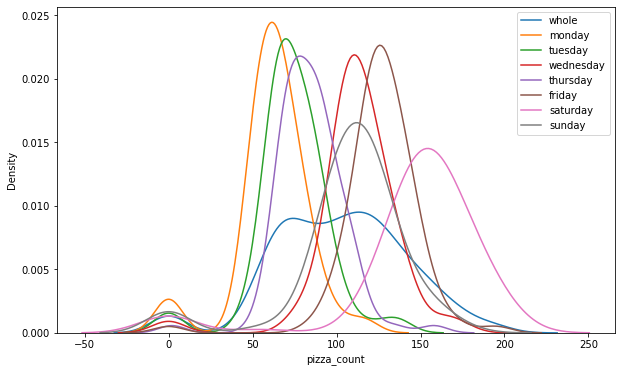

In [138]:
plt.figure(figsize=[10,6])
sns.kdeplot(pizza_daily_copy.pizza_count)
sns.kdeplot(pizza_daily_copy.loc[pizza_daily_copy.weekday==0].pizza_count)
sns.kdeplot(pizza_daily_copy.loc[pizza_daily_copy.weekday==1].pizza_count)
sns.kdeplot(pizza_daily_copy.loc[pizza_daily_copy.weekday==2].pizza_count)
sns.kdeplot(pizza_daily_copy.loc[pizza_daily_copy.weekday==3].pizza_count)
sns.kdeplot(pizza_daily_copy.loc[pizza_daily_copy.weekday==4].pizza_count)
sns.kdeplot(pizza_daily_copy.loc[pizza_daily_copy.weekday==5].pizza_count)
sns.kdeplot(pizza_daily_copy.loc[pizza_daily_copy.weekday==6].pizza_count)
plt.legend(['whole', 'monday', 'tuesday', 
            'wednesday', 'thursday', 'friday','saturday', 'sunday'])
plt.show()

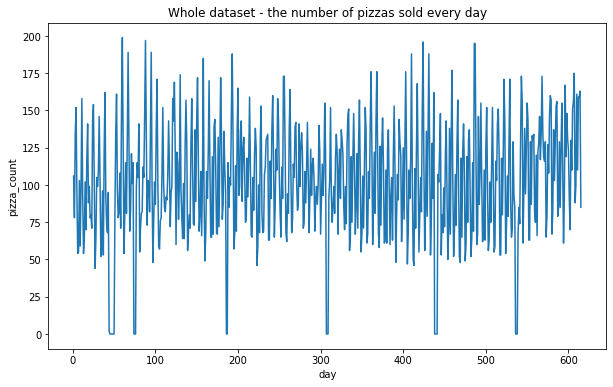

In [139]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pizza_daily_copy, x=pizza_daily_copy.index.values, y='pizza_count')
plt.title("Whole dataset - the number of pizzas sold every day")
plt.xlabel("day")
plt.show()

In [140]:
def plot_series(time, series, start=0, end=None, format='-', labels=None):
    plt.plot(time[start:end], series[start:end], format, label=labels)
    plt.xlabel("Time")
    plt.ylabel('Value')
    if labels:
        plt.legend(fontsize=14)
    plt.grid(True)

In [141]:
pizza_daily_copy = pizza_daily_copy[['year','month','day','weekday',
                                     'working_day','public_holiday','pizza_count']]

<a id="model"></a>
### 5. Creating a model

Averaging zeros based on days of weeks to remove noise from the model.

In [142]:
pizza_daily_copy.loc[(pizza_daily_copy.pizza_count == 0)&(pizza_daily_copy.weekday == 0), 'pizza_count'] = 63
pizza_daily_copy.loc[(pizza_daily_copy.pizza_count == 0)&(pizza_daily_copy.weekday == 1), 'pizza_count'] = 74
pizza_daily_copy.loc[(pizza_daily_copy.pizza_count == 0)&(pizza_daily_copy.weekday == 2), 'pizza_count'] = 112
pizza_daily_copy.loc[(pizza_daily_copy.pizza_count == 0)&(pizza_daily_copy.weekday == 3), 'pizza_count'] = 84
pizza_daily_copy.loc[(pizza_daily_copy.pizza_count == 0)&(pizza_daily_copy.weekday == 4), 'pizza_count'] = 127
pizza_daily_copy.loc[(pizza_daily_copy.pizza_count == 0)&(pizza_daily_copy.weekday == 5), 'pizza_count'] = 147
pizza_daily_copy.loc[(pizza_daily_copy.pizza_count == 0)&(pizza_daily_copy.weekday == 6), 'pizza_count'] = 108

In [143]:
pizza_daily_copy.head()

,year,month,day,weekday,working_day,public_holiday,pizza_count
new_index,,,,,,,
1,2016,10,12,2,1,0,106
2,2016,10,13,3,1,0,78
3,2016,10,14,4,1,0,134
4,2016,10,15,5,0,0,152
5,2016,10,16,6,0,0,94


In [144]:
pizza_daily_copy_date = pd.concat([pd.to_datetime(pizza_daily_copy[['year', 'month', 'day']]), pizza_daily_copy.weekday,pizza_daily_copy.working_day,pizza_daily_copy.public_holiday,pizza_daily_copy.pizza_count], axis=1)
pizza_daily_copy_date = pizza_daily_copy_date.rename(columns={0:"date"})
pizza_daily_copy_date.head()

,date,weekday,working_day,public_holiday,pizza_count
new_index,,,,,
1,2016-10-12,2,1,0,106
2,2016-10-13,3,1,0,78
3,2016-10-14,4,1,0,134
4,2016-10-15,5,0,0,152
5,2016-10-16,6,0,0,94


In [145]:
def add_unix(row):
    return pd.Timestamp(row['date']).timestamp()

In [146]:
pizza_daily_copy_date_unix = pizza_daily_copy_date.copy()
pizza_daily_copy_date_unix['date'] = pizza_daily_copy_date_unix.apply(lambda row: add_unix(row), axis=1)
pizza_daily_copy_date_unix.head()

,date,weekday,working_day,public_holiday,pizza_count
new_index,,,,,
1,1.476230e+09,2,1,0,106
2,1.476317e+09,3,1,0,78
3,1.476403e+09,4,1,0,134
4,1.476490e+09,5,0,0,152
5,1.476576e+09,6,0,0,94


In [147]:
X, y = pizza_daily_copy.iloc[:,:-1], pizza_daily_copy.pizza_count
X_unix, y_unix = pizza_daily_copy_date_unix.iloc[:,:-1], pizza_daily_copy_date_unix.pizza_count

# We want to split data into 3 parts - train, test, validation and use validation only for testing the final model
X_for_modeling, X_for_validation, y_for_modeling, y_for_validation = train_test_split(X, y, shuffle=False, test_size=61) 
X_for_modeling_unix, X_for_validation_unix, y_for_modeling_unix, y_for_validation_unix = train_test_split(X_unix, y_unix, shuffle=False, test_size=61) 

# In this step we split data for modelling to find best algorithm, tune parameters and assess performance
X_train, X_test, y_train, y_test = train_test_split(X_for_modeling, y_for_modeling, shuffle=False, test_size=61)
X_train_unix, X_test_unix, y_train_unix, y_test_unix = train_test_split(X_for_modeling_unix, y_for_modeling_unix, shuffle=False, test_size=61)

#### a) baseline model

Prediction of wednesday's pizza_count is a mean of all wednesday's pizza_count in training set 

In [148]:
baseline_test = y_test.to_frame()
baseline_test['predicted_pizza_count'] = 0

In [149]:
X_train['pizza_count'] = y_train.values

<ipython-input-149-9eee0aacbd8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pizza_count'] = y_train.values


In [150]:
for index, row in X_test.iterrows():
    baseline_test.loc[index, 'predicted_pizza_count'] = \
                                X_train.loc[X_train.weekday==row.weekday].pizza_count.mean()

In [151]:
baseline_test['difference'] = baseline_test.apply(lambda x: abs(x['predicted_pizza_count'] - x['pizza_count']), axis=1)

In [152]:
print("MAE calculated \"by handy\": ", baseline_test.difference.mean())
print("Sum of errors: ", baseline_test.difference.sum())
print("MSE: ", mean_squared_error(y_test, baseline_test.predicted_pizza_count))
print("MAE using built-in formula: ", mean_absolute_error(y_test, baseline_test.predicted_pizza_count))

MAE calculated "by handy":  11.42430319622654
Sum of errors:  696.8824949698189
MSE:  227.0072363607379
MAE using built-in formula:  11.42430319622654


#### b) more advanced modeling

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_for_modeling, y_for_modeling, shuffle=False, test_size=61)

#### 1. Linear regression

In [154]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
prediction_lr = model_lr.predict(X_test)

In [155]:
mean_absolute_error(y_test, prediction_lr)

21.010120479046794

In [156]:
model_lr = LinearRegression()
model_lr.fit(X_train_unix, y_train_unix)
prediction_lr_unix = model_lr.predict(X_test_unix)

mean_absolute_error(y_test, prediction_lr_unix)

20.871032262512262

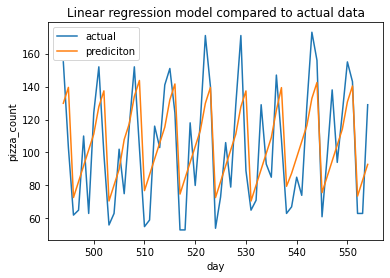

In [157]:
sns.lineplot(x=y_test.index.values, y=y_test)
sns.lineplot(x=y_test.index.values, y=prediction_lr)
plt.legend(['actual', 'prediciton'])
plt.title("Linear regression model compared to actual data")
plt.xlabel("day")
plt.show()

##### 2. Gradient boosting regression

In [158]:
model_gbt = GradientBoostingRegressor()
model_gbt.fit(X_train, y_train)
prediction_gbt = model_gbt.predict(X_test)

In [159]:
mean_absolute_error(y_test, prediction_gbt)

10.726090551945891

In [68]:
model_gbt = GradientBoostingRegressor()
model_gbt.fit(X_train_unix, y_train_unix)
prediction_gbt_unix = model_gbt.predict(X_test_unix)

mean_absolute_error(y_test_unix, prediction_gbt_unix)

16.117502044825688

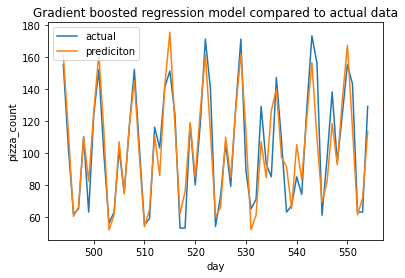

In [69]:
sns.lineplot(x=y_test.index.values, y=y_test)
sns.lineplot(x=y_test.index.values, y=prediction_gbt)
plt.legend(['actual', 'prediciton'])
plt.title("Gradient boosted regression model compared to actual data")
plt.xlabel("day")
plt.show()

##### 3. Moving average

In [70]:
# Moving average averages data in some interval and applies to mean to the right next value (predicts next datapoint)
def moving_average(series, window_size):
    forecast=[]
    for time in range(len(series) - window_size):
        forecast.append(series[time : time+window_size].mean())
    return pd.Series(forecast)

In [71]:
seasonality_window = 7
window_size = 7

X_for_modeling['pizza_count'] = y_for_modeling.values
x_y_for_modeling = X_for_modeling

x_y_no_season = pd.Series(pd.Series.to_numpy(x_y_for_modeling.pizza_count[seasonality_window: ]) - \
                            pd.Series.to_numpy(x_y_for_modeling.pizza_count[ :-seasonality_window]))


<ipython-input-71-ae654a6e3d85>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_for_modeling['pizza_count'] = y_for_modeling.values


In [72]:
split_time = x_y_no_season.shape[0]-61  # place where we split train and testing data (testing data.shape=61)

x_y_test = moving_average(x_y_no_season, window_size)[-61:]

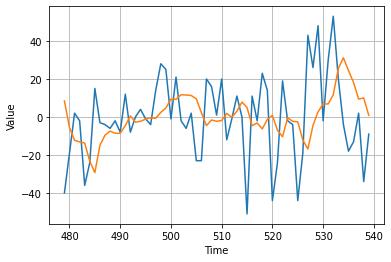

In [73]:
plot_series(x_y_test.index.values, x_y_no_season[-61:])

plot_series(x_y_test.index.values, x_y_test)

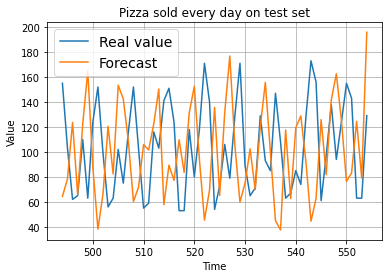

In [74]:
test_forecast_no_moving_avg = np.array(x_y_for_modeling.pizza_count[-61-61-seasonality_window: -61-seasonality_window]) \
                                + np.array(x_y_test)                              


plot_series(x_y_for_modeling[-61:].index.values, x_y_for_modeling[-61:].pizza_count, labels='Real value')

plot_series(x_y_for_modeling[-61:].index.values, test_forecast_no_moving_avg, labels='Forecast')
plt.title("Pizza sold every day on test set")
plt.show()

In [75]:
mean_absolute_error(x_y_for_modeling[-61:].pizza_count, test_forecast_no_moving_avg)

49.86182669789226

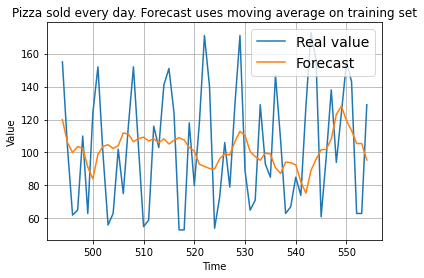

In [76]:
test_forecast_with_moving_avg = moving_average(
                                    x_y_for_modeling.pizza_count[-61-61-window_size-seasonality_window: -61-seasonality_window],
                                    window_size) 
test_forecast_with_moving_avg = np.array(test_forecast_with_moving_avg) + np.array(x_y_test)                              


# Plot the forecast against real values on test set
plot_series(x_y_for_modeling[-61:].index.values, x_y_for_modeling[-61:].pizza_count, labels='Real value')
plot_series(x_y_for_modeling[-61:].index.values, test_forecast_with_moving_avg, labels='Forecast')
plt.title("Pizza sold every day. Forecast uses moving average on training set")
plt.show()

Smoothness of the forecast comes from using moving average on training set

In [77]:
mean_absolute_error(x_y_for_modeling[-61:].pizza_count, test_forecast_with_moving_avg)

30.87822014051522

In [78]:
scaler_train = MinMaxScaler().fit_transform(X_train)
scaler_test = MinMaxScaler().fit_transform(X_test)

In [79]:
scaler_train2 = RobustScaler().fit_transform(X_train)
scaler_test2 = RobustScaler().fit_transform(X_test)

In [80]:
model_gbr2 = GradientBoostingRegressor()

parameters = {
    'learning_rate':[0.01, 0.05, 0.1, 0.13, 0.15, 0.2],
    'n_estimators':[20, 40, 60, 80, 100, 150, 200, 250, 300, 400, 500, 600, 700],
    'loss':['ls', 'lad', 'huber', 'quantile']
}
tscv = TimeSeriesSplit(n_splits=5)
evaluation_metric = make_scorer(mean_absolute_error, greater_is_better=False)


model_gbr2.fit(X_train, y_train)
prediction_gbr2 = model_gbr2.predict(X_test)

In [81]:
model_gbr2

GradientBoostingRegressor()

In [82]:
mean_absolute_error(y_test, prediction_gbr2)

10.746556313741845

In [83]:
model_gbr2.fit(X_train_unix, y_train_unix)
prediction_gbr2_unix = model_gbr2.predict(X_test_unix)
mean_absolute_error(y_test_unix, prediction_gbr2_unix)

16.117502044825684

4. Recurrent Neural Network

In [84]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [85]:
pizza_rnn = pizza_daily_copy_date.drop(['weekday','working_day','public_holiday'],axis=1).set_index('date')
pizza_rnn.head()

,pizza_count
date,
2016-10-12,106
2016-10-13,78
2016-10-14,134
2016-10-15,152
2016-10-16,94


In [86]:
train = pizza_rnn[:-60]
test = pizza_rnn[-60:]

In [87]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [88]:
length = 31
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [89]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [90]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [91]:
history = model.fit(generator,epochs=20,
                    validation_data=validation_generator)

Epoch 1/20
524/524 [==============================] - 4s 5ms/step - loss: 0.1663 - val_loss: 0.0290
Epoch 2/20
524/524 [==============================] - 2s 5ms/step - loss: 0.0328 - val_loss: 0.0291
Epoch 3/20
524/524 [==============================] - 2s 5ms/step - loss: 0.0322 - val_loss: 0.0295
Epoch 4/20
524/524 [==============================] - 3s 5ms/step - loss: 0.0364 - val_loss: 0.0306
Epoch 5/20
524/524 [==============================] - 2s 5ms/step - loss: 0.0326 - val_loss: 0.0338
Epoch 6/20
524/524 [==============================] - 2s 5ms/step - loss: 0.0265 - val_loss: 0.0292
Epoch 7/20
524/524 [==============================] - 3s 5ms/step - loss: 0.0245 - val_loss: 0.0303
Epoch 8/20
524/524 [==============================] - 3s 5ms/step - loss: 0.0231 - val_loss: 0.0326
Epoch 9/20
524/524 [==============================] - 2s 5ms/step - loss: 0.0224 - val_loss: 0.0498
Epoch 10/20
524/524 [==============================] - ETA: 0s - loss: 0.021 - 3s 5ms/step - loss: 0

<AxesSubplot:>

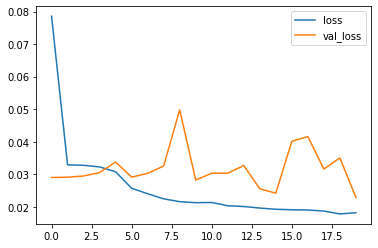

In [92]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [93]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

<ipython-input-94-49d487fd72d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='date'>

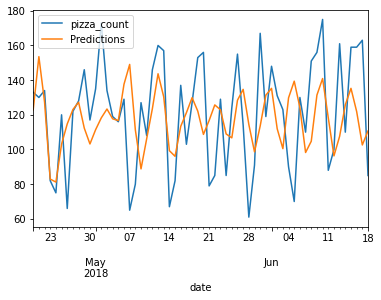

In [94]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot()

In [95]:
mean_absolute_error(test['pizza_count'],test['Predictions'])

24.798846460382144